In [1]:
%load_ext autoreload
%autoreload

# Introduction to scikit-learn
---
## What is scikit-learn
`scikit-learn`, or in short `sklearn`, is a free software machine learning python framework, which contains  useful tools making life easier on both feature engineering and model training.

## What are provided in scikit-learn
1. There are lots of free dataset provided in the scikit-learn. For linear regression and prediction models e.g. `sklearn.datasets.california_housing` provides the house price record in California around 1997, while the performance of an anomaly detection model can be tried on the KDDCUP dataset in 1999 `sklearn.datasets.kddcup99`
2. Training-Test-Validation trade off plays a critical role in the machine learning game. Choosing data splitting rate wisely and you can avoid problems such as overfitting or underfitting. Tools like `sklearn.cross_validation.bootstrap` and `sklearn.model_selection.train_test_split` shed the light on data splitting. 
3. Famous machine learning models, such as SVM (vanilla version and variations, under `sklearn.svm`), linear regression models (`sklearn.linear_model.{LinearRegression, Lasso, Ridge}`), clustering models (like `sklearn.cluster.KMeans`) are integrated into the framework
4. `sklearn.pipeline` module introduces a new data structure that chain your data cleaning module, feature engineering module and training model together. The input of the assembled pipeline is usually (a subset of) the raw data and thus the whole pipeline can be cross validated once and together.

In [2]:
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

In [3]:
#import tensorflow.contrib.eager as tfe
#tfe.enable_eager_execution()
import os
import copy
import numpy as np
import collections
from copy import deepcopy
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import Counter

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import seaborn as sns

In [6]:
def kaggle_dataset_maybe_download(category, dataset_name, data_folder, data_fname):
    """
    Load the csv file named as data_fname from Kaggle house prices prediction 
    competition dataset from data_folder, if the file is already downloaded. 
    Function raises an exception if no such file found to notify you to run download
    it using Kaggle api. Or you can also simply download it from:
    https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data#
    manually and put it into your dafa_folder.
    
    Parameters
    ----------
    category: str
        Name of the category the dataset is in on Kaggle, can be 'competitions' 
        for example. Details see https://github.com/Kaggle/kaggle-api#.
    dataset_name: str
        The name of this dataset on Kaggle.
    data_folder: str
        The directory the dataset files are saved.
    data_fname: str
        The name of the specific data file.
    Returns
    ---------
    data: pandas.DataFrame
        The file is read and loaded as a DataFrame in module pandas.
    Raises
    --------
    FileNotFoundError
        If the dataset specified is not stored on the disk, the function notifies 
        you to download the datafile and store it into the right place. Then raises
        the FileNotFoundError to its caller and halt the excution.
    """
    try:
        data = pd.read_csv(os.path.join(data_folder, data_fname), index_col='Id')
    except FileNotFoundError:
        cmd = 'kaggle {} download -c {} -p {} -f {}'.format(category, dataset_name, data_folder, data_fname)
        print('Please run: {}'.format(cmd))
        print('to download file {} at first'.format(fname))
        raise FileNotFoundError
    return data

In [7]:
def get_dataset(data_name, data_folder='/tmp/dl_data', test_prop=0.2):
    """
    Get dataset from Kaggle or from Ujwal and split it into 3 subsets i.e. training, 
    test and validation sets.
    
    Parameters
    --------
    data_name: str
        Can be {'house_prices', 'uj'}, specifies the name of dataset. You can also 
        integrate the loading function of your own dataset.
    data_folder: str
        The directory where those dataset are stored. Default '/tmp/dl_data'. Under
        this directory sub-folders can be made to make the data folder clean and organized.
    test_prop: float
        The proportion of the test set taken from the whole original dataset. Default
        0.2 (1/5).
    Returns
    --------
    training, test: pandas.DataFrame
        Corresponding datasets
    label_name: str
        The name of the label column.
    """
    if data_name == 'house_prices':
        data_desc_fname, submit_sample_fname, test_fname, train_fname = 'data_description.txt  sample_submission.csv  test.csv  train.csv'.split()
        data_folder = os.path.join(data_folder, 'kaggle_competitions', 'house_prices')
        if not os.path.isdir(data_folder):
            cmd = 'mkdir -pv ' + data_folder
            os.system(cmd)
        
        fnames = [submit_sample_fname, test_fname, train_fname]
        dsmd_fxn = lambda x: kaggle_dataset_maybe_download(category='competitions', 
                                                           dataset_name='house-prices-advanced-regression-techniques',
                                                           data_folder=data_folder,
                                                           data_fname=x)
        submit_sample, test, train = list(map(dsmd_fxn, fnames))
        test = test.merge(submit_sample, on='Id')
        label_name = 'SalePrice'

    elif data_name == 'uj':
        DATA_DIR = './data/'
        dataset_fname = os.path.join(DATA_DIR, 'UG_HH_NEW_categorical_no200.xls')
        dataset_fname = os.path.join(DATA_DIR, 'UG_HH_NEW_continuous_no200.xls')
        if 'categorical' in dataset_fname:
            feature_names = ['q{}'.format(str(i)) for i in range(1, 30)]
            label_name = 'q30'
        else:
            feature_names = 'prop	other_resp	other_prop	time_spent_risk	cells	selfish	time_spent_prop	count_effort	Honesty_Humility	Extraversion	Agreeableness'.split()
            label_name = 'min_offer'
        column_names = feature_names + [label_name]
        if dataset_fname.endswith('xls'):
            raw_dataset = pd.read_excel(dataset_fname)
        else:
            raw_dataset = pd.read_csv(dataset_fname, names=column_names,
                                      na_values='.', skipinitialspace=True)
        test = dataset.sample(frac=test_prop, random_state=0)
        train = dataset.drop(test.index)
    
    return train, test, label_name

In [8]:
train, test, label_name = get_dataset('house_prices')
train_copy = deepcopy(train)
test_copy = deepcopy(test)
train[:4]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  

[4 rows x 80 columns]

## Data preprocess
---
After reading the data, we need to massage the data so that our model can train on it in the best situation. Here we will demonstrate categorical one-hot conversion and numerical standardization.

In [9]:
cate_cnames = 'MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition'.split(', ')
num_cnames = [cname for cname in train.columns if cname not in cate_cnames]

### Categorical data

#### Filling missing value with constant
There will always be missing values in the training/test data, they might due to the storage loss or missed when recording, or sometimes the data naturally doesn't exist. For the categorical data, those missing values sometimes can be considered naturally become a new category. The code in the following cell replaces the missing value with a constant string `NA`.

In [10]:
from sklearn.impute import SimpleImputer

cate_imputer = SimpleImputer(strategy='constant', fill_value='NA')
cate_imputer.fit(train[cate_cnames])
train[cate_cnames] = cate_imputer.transform(train[cate_cnames])

train[:4]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave    NA      Reg   
2           20       RL         80.0     9600   Pave    NA      Reg   
3           60       RL         68.0    11250   Pave    NA      IR1   
4           70       RL         60.0     9550   Pave    NA      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0     NA    NA          NA   
2          Lvl    AllPub       FR2  ...        0     NA    NA          NA   
3          Lvl    AllPub    Inside  ...        0     NA    NA          NA   
4          Lvl    AllPub    Corner  ...        0     NA    NA          NA   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  

[4 rows x 80 columns]

#### Convert categorical data to one hot columns
Assume we have two categorical column `age_interval = {0~18, 19~36, 37~54}` and `fruit = {apple, orange, banana}` on our hand, in order to use it in the numerical regression we have to convert it into numeric data. 

For the `age` one we can simply use integers `{0, 1, 2}` to replace the original category, because there is already an order built for the original data, anyways the one in age 18~36 is always older than whom in age 0~18. 

However, when converting the `fruit` column we have problems with this strategy, i.e. we cannot decide whether `orange` is larger or smaller than `apple`. Therefore simply replacing with integers doesn't work. In this case we can split the `fruit` column into 3 (or 4, considering missed data) mutual exclusive columns, i.e. `{fruit_apple, fruit_orange, fruit_banana}`, sometimes together with `fruit_NaN`. Whenever a row contains `apple` in the original `fruit` column, the new `fruit_apple` is set to 1 and both `fruit_orange` and `fruit_banana` columns are set to 0. 

With the help of `sklearn.preprocessing.OneHotEncoder` we can convert categorical data into such one-hot encoding data in a way that is easy and consistent with the rest components. The `handling_unknown` argument in the initialization of the encoder is useful in such situation, that sometimes for a categorical feature we might be not able to see all the candidates for this feature. For those categories unseen in the training dataset there is no chance we can learn from it. In this case we can share the one-hot encoder fit to the training data  for both preprocessing of training and test data, where the encoder simply ignore the unseen value in the test data and set all corresponding one-hot lines to $0$. There is also a one-hot encoder provided in `pandas` called `pandas.get_dummies`.

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_encoder.fit(train[cate_cnames])

one_hot_features = one_hot_encoder.get_feature_names(input_features=cate_cnames)
one_hot_data = pd.DataFrame(one_hot_encoder.transform(train[cate_cnames]), columns=one_hot_features)

train.drop(cate_cnames, axis=1, inplace=True)
train = pd.concat([train, one_hot_data], axis=1)

train[:4]

MSSubClass  LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0         NaN          NaN      NaN        NaN           NaN         NaN   
1        60.0         65.0   8450.0     2003.0        2003.0       196.0   
2        20.0         80.0   9600.0     1976.0        1976.0         0.0   
3        60.0         68.0  11250.0     2001.0        2002.0       162.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_ConLw  \
0         NaN         NaN        NaN          NaN  ...             0.0   
1       706.0         0.0      150.0        856.0  ...             0.0   
2       978.0         0.0      284.0       1262.0  ...             0.0   
3       486.0         0.0      434.0        920.0  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0          1.0                    0.0   
1           0.0           0.0          1.0                    0.0   
2           0.0           0.0          1.0                    0.0   
3           0.0           0.0          1.0                    1.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                   1.0                    0.0  
1                   1.0                    0.0  
2                   1.0                    0.0  
3                   0.0                    0.0  

[4 rows x 322 columns]

#### Pipeline
With the help of `sklearn.pipeline.Pipeline` we can even chain those above together.

In [12]:
from sklearn.pipeline import Pipeline
cate_preprocessor = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
train = deepcopy(train_copy)
cate_preprocessor.fit(train[cate_cnames])

one_hot_features = cate_preprocessor.steps[1][1].get_feature_names(input_features=cate_cnames)
one_hot_data = pd.DataFrame(cate_preprocessor.transform(train[cate_cnames]), columns=one_hot_features)

train.drop(cate_cnames, axis=1, inplace=True)
train = pd.concat([train, one_hot_data], axis=1)

train[:4]

MSSubClass  LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0         NaN          NaN      NaN        NaN           NaN         NaN   
1        60.0         65.0   8450.0     2003.0        2003.0       196.0   
2        20.0         80.0   9600.0     1976.0        1976.0         0.0   
3        60.0         68.0  11250.0     2001.0        2002.0       162.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_ConLw  \
0         NaN         NaN        NaN          NaN  ...             0.0   
1       706.0         0.0      150.0        856.0  ...             0.0   
2       978.0         0.0      284.0       1262.0  ...             0.0   
3       486.0         0.0      434.0        920.0  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0          1.0                    0.0   
1           0.0           0.0          1.0                    0.0   
2           0.0           0.0          1.0                    0.0   
3           0.0           0.0          1.0                    1.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                   1.0                    0.0  
1                   1.0                    0.0  
2                   1.0                    0.0  
3                   0.0                    0.0  

[4 rows x 322 columns]

### Numerical Data

#### Filling NaNs
There are still some hedious `NaN`s in the numerical columns, we need to fill them out. Like what have been done to the categorical data, the `NaN`s can also be filled with the imputer, only this time we use a different strategy: imputing the missing data with the mean of the rest.

In [13]:
num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(train[num_cnames])
train[num_cnames] = num_imputer.transform(train[num_cnames])
train[:4]

MSSubClass  LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0        50.0         69.0   9478.5     1973.0        1994.0         0.0   
1        60.0         65.0   8450.0     2003.0        2003.0       196.0   
2        20.0         80.0   9600.0     1976.0        1976.0         0.0   
3        60.0         68.0  11250.0     2001.0        2002.0       162.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_ConLw  \
0       383.5         0.0      477.5        991.5  ...             0.0   
1       706.0         0.0      150.0        856.0  ...             0.0   
2       978.0         0.0      284.0       1262.0  ...             0.0   
3       486.0         0.0      434.0        920.0  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0          1.0                    0.0   
1           0.0           0.0          1.0                    0.0   
2           0.0           0.0          1.0                    0.0   
3           0.0           0.0          1.0                    1.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                   1.0                    0.0  
1                   1.0                    0.0  
2                   1.0                    0.0  
3                   0.0                    0.0  

[4 rows x 322 columns]

#### Normalization or Standardization
It is usually a good practice to normalize or standardize features before training, since some model (e.g. Feed Forward Networks) are sensitive to the scale of data. Normalization usually scales the data up or down to \[-1, 1\] or \[0, 1\]. Or we can standardize the data to have mean 0 and variance 1, if we want to keep the linearity of the data and don't actually care about the absolute value of them. The standardization can be finished using `sklearn.preprocessing.StandardScaler`

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[num_cnames])
train[num_cnames] = scaler.transform(train[num_cnames])
train[:4]

MSSubClass  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0   -0.163052    -0.039210 -0.104027   0.057352      0.442405   -0.570491   
1    0.073511    -0.220924 -0.207141   1.051313      0.878607    0.514613   
2   -0.872742     0.460504 -0.091846   0.156748     -0.429998   -0.570491   
3    0.073511    -0.084638  0.073576   0.985049      0.830140    0.326381   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_ConLw  \
0   -0.131856   -0.288546  -0.203091    -0.150281  ...             0.0   
1    0.575709   -0.288546  -0.944762    -0.459353  ...             0.0   
2    1.172477   -0.288546  -0.641299     0.466724  ...             0.0   
3    0.093029   -0.288546  -0.301603    -0.313371  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0          1.0                    0.0   
1           0.0           0.0          1.0                    0.0   
2           0.0           0.0          1.0                    0.0   
3           0.0           0.0          1.0                    1.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                   1.0                    0.0  
1                   1.0                    0.0  
2                   1.0                    0.0  
3                   0.0                    0.0  

[4 rows x 322 columns]

#### Preprocessing Heterogeneous Data in One Batch
This dataset contains both numerical and categorical data. In practical we may also meet other types of features in the columns, for instance time series, or binary files. In order to preprocess the heterogeneous features simultaneously, we can use `sklearn.compose.ColumnTransformer` to compose the pipe lines together and apply them to according features.

In respect of interpretability, however, it is not yet recommended to use it. According to the issue [#6424](https://github.com/scikit-learn/scikit-learn/issues/6424) and issue [#6425](https://github.com/scikit-learn/scikit-learn/issues/6425) there are some estimators (e.g. `StandardScaler` in the following cell and `Pipeline`s) don't support retrieving of feature names. Which brings lots of trouble for human to understand the transformed data.

In [15]:
from sklearn.compose import ColumnTransformer

train = deepcopy(train_copy)
test = deepcopy(test_copy)
y_train = train.pop(label_name)
x_train = train
y_test = test.pop(label_name)
x_test = test
num_cnames.pop(num_cnames.index(label_name))

num_imputer = SimpleImputer(strategy='median')
'''
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])'''

cate_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

ctransformer = ColumnTransformer(transformers=[
    ('num', num_imputer, num_cnames),
    ('cat', cate_transformer, cate_cnames)
])

preprocessor = Pipeline(steps=[
    ('ctransformer', ctransformer),
    ('scaler', StandardScaler())
])
'''
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_cnames),
        ('cat', categorical_transformer, cate_cnames)
])'''

preprocessor.fit(train)
x_train = preprocessor.transform(x_train)
x_test = preprocessor.transform(x_test)

In [16]:
y_train = StandardScaler().fit_transform(y_train.to_numpy().reshape((-1, 1)))
y_test = StandardScaler().fit_transform(y_test.to_numpy().reshape((-1, 1)))

/home/assassin/.conda/envs/python36_tf2/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/assassin/.conda/envs/python36_tf2/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Observing data
---
Before we get our hand dirty and to train the data, it is very important to inspect the data and build your hypothesis. After all we can learn nothing if features and label are mutually independent.

Here we uses seaborn to inspect the pairwise correlation of some features and the label column. Sub-figure at $(x, y)$ depicts the relationship between $x$ and $y$, if $x \neq y$. Those on the main-diagonal (sub-figures at $(x, x)$) are the smoothed distribution of feature $x$. From this example we can see, for example, the `LotFrontage` column is somehow positive related with the label `SalePrice`, but the perturbation is also large.

/home/assassin/.conda/envs/python36_tf2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/assassin/.conda/envs/python36_tf2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


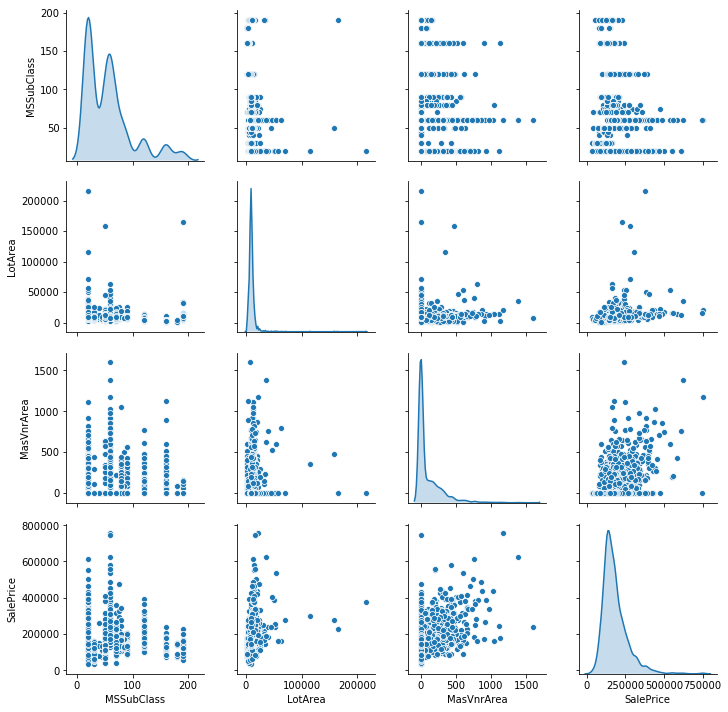

In [17]:
sns.pairplot(train_copy[['MSSubClass', 'LotArea', 'MasVnrArea', label_name]], diag_kind="kde")

## Linear regression models
----

### Ordinary linear regressor from sklearn
According to the document of scikit-learn, the `LinearRegressor` class is simply a wrapper of `scipy.linalg.lstsq`, least square implementation from `scipy`. Here we wrap it one more time to keep the class structure consistent using hierarchical inheriting. 

In [18]:
model = LinearRegression()

Usually we can call the `fit()` method of a `scikit-learn` model to train the model to fit the data fed as well as possible.

In [19]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
model.predict(x_train)

array([[ 0.34456079],
       [ 0.22395532],
       [ 0.33394068],
       ...,
       [ 1.14210718],
       [-0.45963843],
       [-0.42536719]])

Lots `scikit-learn` models have `score()` method to evaluate the performance of a model on given data. The score is in default [https://en.wikipedia.org/wiki/Coefficient_of_determination](coefficient of determination), a.k.a. $R^2$ (don't confuse it with mean squared error, despite the square in its nick name). It describes the coefficient of the prediction and the label. An ideal model produces $1.0$ as its $R^2$ score, while a constant model that always produce mean of the label has the $R^2$ of $0.0$. Since he model can be arbitrarily bad, the coefficient of determination has no lower bound.

In [21]:
model.score(x_train, y_train)

0.9381029542892185

In [22]:
model.score(x_test, y_test)

-2.0353302019473368e+24

The $R^2$ score on the training data is pretty good, but the model performs extremely awful on the test set. Experience tells us that overfitting must happens. This implies that we need to restrict the complexity of the model, or add some regularization.

### Linear regression with lasso regularization
[`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) is a linear regression model with lasso regularization, it minimizes the objective 
\begin{equation}
\frac{1}{2 * n_{samples}} * ||y - Xw||^2_2 + \alpha * ||w||_1, 
\end{equation}
where $\frac{1}{n_{samples}} * ||y - Xw||^2_2$ is the averaged square error and $\alpha * ||w||_1$ is the regularization term with the factor $\alpha$. The optimization uses [coordinate descent](https://en.wikipedia.org/wiki/Coordinate_descent)

In [23]:
from sklearn.linear_model import Lasso

In [24]:
model = Lasso(alpha=0.01, max_iter=100000, warm_start=False, tol=1e-4, selection='random', random_state=0)

In [25]:
model.fit(x_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='random', tol=0.0001, warm_start=False)

In [26]:
model.score(x_train, y_train)

0.9249879681311661

In [27]:
model.score(x_test, y_test)

-0.3283329152937067

### ...or with ridge regularization
[sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is the linear regression model with ridge regularization, whose objective is 
\begin{equation}
||y - Xw||^2_2 + \alpha * ||w||^2_2
\end{equation}

In [28]:
from sklearn.linear_model import Ridge

In [29]:
model = Ridge(alpha=1, normalize=True)

In [30]:
model.fit(x_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
   random_state=None, solver='auto', tol=0.001)

In [31]:
model.score(x_train, y_train)

0.8947253123658157

In [32]:
model.score(x_test, y_test)

-0.26036984657152296

### ... or both
`sklearn.linear_model.ElasticNet` implements the ElasticNet model, which combines both $L_1$ and $L_2$ regularization together. Therefore the objective of an ElasticNet model is
\begin{equation}
\frac{1}{2 * n_samples} * ||y - Xw||^2_2 + \alpha * r_{l1} * ||w||_1+ 0.5 * \alpha * (1-r_{l1}) * ||w||^2_2
\end{equation}

In [33]:
from sklearn.linear_model import ElasticNet

In [34]:
model = ElasticNet(l1_ratio=0.01, alpha=0.2)

In [35]:
model.fit(x_train, y_train)

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
model.score(x_train, y_train)

0.9260644774304776

In [37]:
model.score(x_test, y_test)

-0.33390476793181634

### The effect of regularization
As we might have already known, the regularization can diminish overfitting in a certain degree. But how do we understand the effect of regularization intuitively?

Let's inspect this with the help of a very simple example, i.e. fitting the line 
\begin{equation}
y=7x+5
\end{equation}
by regress the slope $w$ and the intercept $b$ using linear regression on some perturbed data:

In [38]:
x = np.linspace(-10, 10, 21)
y = 7 * x + 5 + (2.*np.random.random(21) - 1)

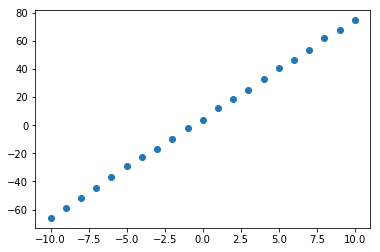

In [39]:
plt.scatter(x,y)

Let the RSS error between the prediction and the real value be our loss function, i.e. $||\hat{y} - y||_2^2$, and the loss 'field' around the real value $(7, 5)$ looks like:

In [40]:
def draw_contour(W, B, Z, title):
    fig, ax = plt.subplots(constrained_layout=True)
    cs = ax.contourf(W, B, Z, 10, cmap=plt.cm.Blues, origin='lower')
    cs2 = ax.contour(cs, levels=cs.levels, colors='g', origin='lower')
    ax.scatter([0], [0], color='r')
    ax.set_title(title)
    ax.set_xlabel('w')
    ax.set_ylabel('b')
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel('loss')
    cbar.add_lines(cs2)
    return fig, ax

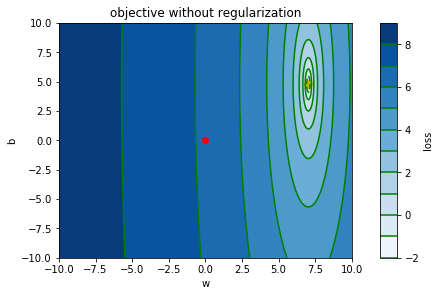

In [41]:
W = np.concatenate([np.linspace(-10, 10, 400)])
B = copy.deepcopy(W)
W, B = np.meshgrid(W, B)
obj = np.array([[np.log(np.sum(np.square(w*x + b - y))/(2*21)) for w, b in zip(w_row, b_row)] for w_row, b_row in zip(W, B)])
fig, ax = draw_contour(W, B, obj, 'objective without regularization')
w_opt_orig = (x*y).mean()/(x**2).mean()
b_opt_orig = y.mean()
ax.scatter([w_opt_orig], [b_opt_orig], color='y', marker='D')

Note that it is actually logarithmic of the loss value that to be shown in the figure. The red point in the figure indicates the origin, while the point $(7, 5)$ is represented with a yellow diamond. Green contours filled with different saturations of blue shows (logarithmic of) loss values.

The $L_1$ and $L_2$ regularization terms along look like the follows:

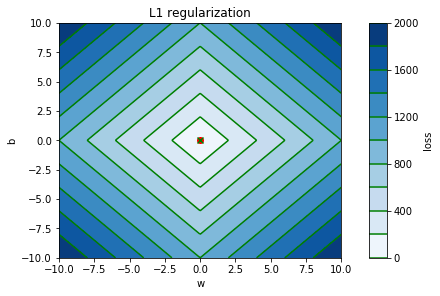

In [42]:
l1 = np.array([[(100 * (np.abs(w)+np.abs(b))) for w, b in zip(w_row, b_row)] for w_row, b_row in zip(W, B)])
fig, ax = draw_contour(W, B, l1, 'L1 regularization')
ax.scatter([0], [0], color='g', marker='x')

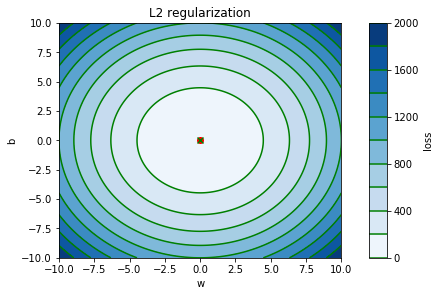

In [43]:
l2 = np.array([[(10 * (w**2+b**2)) for w, b in zip(w_row, b_row)] for w_row, b_row in zip(W, B)])
fig, ax = draw_contour(W, B, l2, 'L2 regularization')
ax.scatter([0], [0], color='g', marker='x')

The green crosses shows local minimal of two 'loss functions', which are simply the origin.

Then let's take a look at the field of loss with $L_1$ regularization. Since the contours of it are more 'pointy' on the coordinate axes, a model optimizes loss with $L_1$ regularization tends to find its local minimum on the axes. Therefore most of the coefficients are more likely to be zero. This diminishes the model complexity.

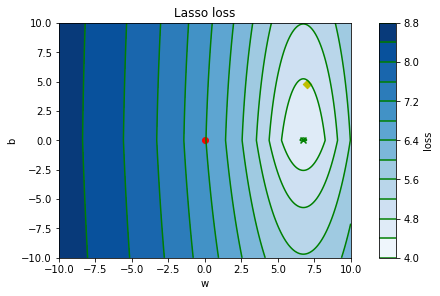

In [44]:
alpha = 10
model = Lasso(alpha=10, max_iter=1000, fit_intercept = False)
# The loss function of which is:
lasso_loss = lambda w, b: (np.sum(np.square(w*x + b - y))/(2*21)) + (alpha * (np.abs(w)+np.abs(b)))
log_obj_lasso = np.array([[np.log(lasso_loss(w, b)) for w, b in zip(w_row, b_row)] for w_row, b_row in zip(W, B)])

model.fit(np.concatenate([x.reshape((len(x), 1)), np.ones((len(x), 1))], axis=1), y.reshape((len(y), 1)))

fig, ax = draw_contour(W, B, log_obj_lasso, 'Lasso loss')

ax.scatter(*model.coef_, color='g', marker='x')
ax.scatter([w_opt_orig], [b_opt_orig], color='y', marker='D')

Or the same with $L_2$ regularization:

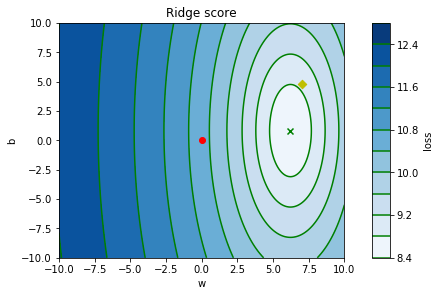

In [45]:
alpha = 100
model = Ridge(alpha=alpha, max_iter=10000, fit_intercept = False)
# whose loss function is:
ridge_loss = lambda w, b: np.sum(np.square(w*x + b - y)) + (alpha * (w**2 + b**2))
log_ridge_loss = np.array([[np.log(ridge_loss(w, b)) for w, b in zip(w_row, b_row)] for w_row, b_row in zip(W, B)])
model.fit(np.concatenate([x.reshape((len(x), 1)), np.ones((len(x), 1))], axis=1), y.reshape((len(y), 1)))
fig, ax = draw_contour(W, B, log_ridge_loss, 'Ridge score')
ax.scatter(*model.coef_[0], color='g', marker='x')
ax.scatter([w_opt_orig], [b_opt_orig], color='y', marker='D')

## validation curve? learning curve? history curve?
----
While training a model, we need to avoid its overfit and underfit. To do that we can either tune the hyperparameters of the model, or control the amount of training data. Namely, we have to answer three questions before we train a model.

* How do we determine its hyper-parameters?
* How many data are needed for training?
* How long should we train?
    
These three questions correspond to three types of 'curve', with which we can track the model's performance during the experiment. Namely:

* **validation curve**: hyper-parameter - model score curve
* **learning curve**  : quantity of training data - model score curve and
* **history curve**   : the variation of model's score along count of training iterations. 

In the following cells we will briefly introduce **validation curve** and **learning curve**, since the **history curve** is actually a special kind of validation curve, where the hyper-parameter to track happens to be the number of iterations.

### validation curve
Validation curve depicts the performance of a model along one of its specific hyper-parameter varies. For instance in the following example, the hyper parameter `alpha` is hyper-parameter to be tuned. `alpha` varies from $10^{-7}$ to $10^3$, $10$ points are selected uniformly in logarithmic manner.

The argument `cv` defines the folds during cross validation. If we set `cv=5` as the example, the data fed is evenly split into $5$ portions. In the $i$-th iteration of validation then, the $i$-th fold is used as the validation set and the rest are used as training set. A paradigm of cross validation for 5 fold is as follows:

                   |                             All data                                |
               
    1st iteration: |1: validation|2: training  |3: training  |4: training  |5: training  |

    2nd iteration: |1: training  |2: validation|3: training  |4: training  |5: training  |

    3rd iteration: |1: training  |2: training  |3: validation|4: training  |5: training  |

    4th iteration: |1: training  |2: training  |3: training  |4: validation|5: training  |

    5th iteration: |1: training  |2: training  |3: training  |4: training  |5: validation|
    
Validation curve is usually used together with grid search to find the optimum setting of hyper-parameters. Here we can see from the validation curve in the following example that the best `alpha` should be somewhere near $10^{-1}$.

In [46]:
X = x_train
y = y_train

In [47]:
from sklearn.model_selection import validation_curve
arg_range = np.linspace(0.01, 450., 20)
train_scores, validation_scores = validation_curve(Ridge(), X, y, 
                                                   param_name="alpha", param_range=arg_range, 
                                                   scoring='r2', cv=5, n_jobs=3)

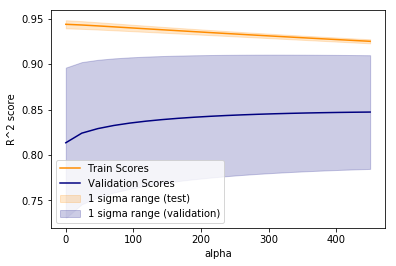

In [48]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
#ax.set_yscale('log')
ax.set_ylabel('R^2 score')
tscore_mean = train_scores.mean(axis=1)
tscore_std = train_scores.std(axis=1)
vscore_mean = validation_scores.mean(axis=1)
vscore_std = validation_scores.std(axis=1)
ax.plot(arg_range, tscore_mean, label='Train Scores', color='darkorange')
ax.plot(arg_range, vscore_mean, label='Validation Scores', color='navy')
ax.fill_between(arg_range, tscore_mean - tscore_std,
                tscore_mean + tscore_std, alpha=0.2,
                color="darkorange", label='1 sigma range (test)')
ax.fill_between(arg_range, vscore_mean - vscore_std,
                vscore_mean + vscore_std, alpha=0.2,
                color="navy", label='1 sigma range (validation)')
ax.legend()

### learning curve
Learing curve describes the relationship between kernel's performance and the quantity of data used in training phase. In the following example, the `Ridge` model is trained on different proportion of all data. The proportion varies from $0.2$ to $1.0$, between that $8$ points are taken evenly spaced.

Note: According to the implementation of the `learning_curve` function, the `cv`-fold (here `cv=5`) cross validation are done after the absolute among of samples is calculated. e.g. There are in total $10$ samples consisting the whole dataset. The cross validation splits the whole dataset into $5$ equi-sized folds, $2$ samples each, if `cv=5`. In the first iteration there are only $6$ samples instead of $8$ to be used as training data, if the train size is set to $0.6$.

In [49]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, validation_scores = learning_curve(Lasso(0.01, warm_start=False),
                                                              X, y, 
                                                              train_sizes=np.linspace(0.2, 1.0, 8), 
                                                              cv=5)

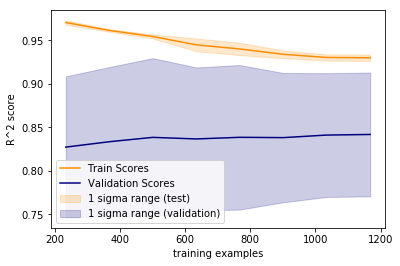

In [50]:
fig, ax = plt.subplots()
ax.set_xlabel('training examples')
ax.set_ylabel('R^2 score')
tscore_mean = train_scores.mean(axis=1)
tscore_std = train_scores.std(axis=1)
vscore_mean = validation_scores.mean(axis=1)
vscore_std = validation_scores.std(axis=1)
ax.plot(train_sizes, tscore_mean, label='Train Scores', color='darkorange')
ax.plot(train_sizes, vscore_mean, label='Validation Scores', color='navy')
ax.fill_between(train_sizes, tscore_mean - tscore_std,
                tscore_mean + tscore_std, alpha=0.2,
                color="darkorange", label='1 sigma range (test)')
ax.fill_between(train_sizes, vscore_mean - vscore_std,
                vscore_mean + vscore_std, alpha=0.2,
                color="navy", label='1 sigma range (validation)')
ax.legend()